In [141]:
import os
import time
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import multiprocess as mp

from functools import partial
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.stats import gaussian_kde, norm, uniform, bernoulli

set_matplotlib_formats("svg")

usr = os.path.expanduser("~")

%matplotlib inline

In [5]:
size = 2000
rng = np.random.default_rng(1)
sample_1 = rng.binomial(n=1, p=0.1, size=size)
sample_2 = rng.binomial(n=1, p=0.13, size=size)

data = pd.DataFrame(
    {
        "y": np.concatenate([sample_1, sample_2]),
        "variant": ["1"] * size + ["2"] * size,
    }
)

In [6]:
variant_mask, variant_ids = pd.factorize(data["variant"])
model = pm.Model(coords={"group": ["1", "2"]})
with model:

    theta = pm.Uniform("theta", 0, 1, dims="group")
    likelihood = pm.Bernoulli(
        "likelihood", p=theta[variant_mask], observed=data["y"]
    )

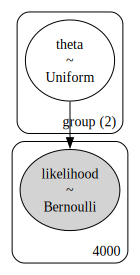

In [7]:
pm.model_to_graphviz(model)

In [8]:
t_0 = time.time()
with model:
    inference = pm.sample(5000, random_seed=np.random.default_rng(1))
print(f"{time.time() - t_0:.2f} seconds")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 58 seconds.


92.85 seconds


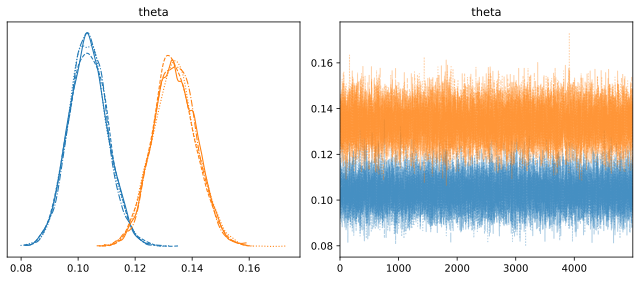

In [9]:
az.plot_trace(inference, backend_kwargs={"figsize": (9, 4)})
plt.tight_layout()

In [10]:
def log_w_eps(x: float) -> float:
    return np.log(x + 1e-20)  # we want logs for zeros as well 

def log_likelihood_prior(
    theta_1: float, theta_2: float, N_1: int,
    N_2: int, z_1: int, z_2: int,
) -> float:
    
    return (
        (z_1 * log_w_eps(theta_1))
        + ((N_1 - z_1) * log_w_eps(1 - theta_1))
        + (z_2 * log_w_eps(theta_2))
        + ((N_2 - z_2) * log_w_eps(1 - theta_2))
    )

In [168]:
def propose(current: np.array) -> np.array:
    mean = np.array([0, 0])
    covar = np.diag([0.01, 0.01])
    proposed_delta = np.random.multivariate_normal(mean, covar)
    return np.clip(current + proposed_delta, 0, 1)

def metropolis_sampling(
    log_likelihood_prior: callable,
    start: list,
    n_steps: int,
) -> np.array:
    
    chain = np.empty((n_steps, 2), dtype=np.float64)
    chain[0, :] = start

    for i in range(1, n_steps - 1):
        current = chain[i - 1]
        proposal = propose(current)
        prob_move = np.exp(
            log_likelihood_prior(*proposal)
            - log_likelihood_prior(*current)
        )

        if np.random.rand() < prob_move:
            chain[i, :] = proposal
        else:
            chain[i, :] = current

    return chain

In [170]:
f = partial(
    log_likelihood_prior,
    N_1=len(sample_1), N_2=len(sample_2),
    z_1=sum(sample_1), z_2=sum(sample_2),
)

t_0 = time.time()
np.random.seed(1)
chain = metropolis_sampling(f, [0.1, 0.1], 100_000)
print(f"{time.time() - t_0:.2f} seconds")

12.87 seconds


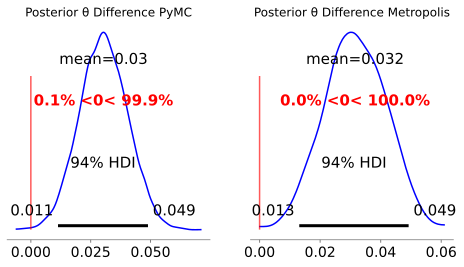

In [172]:
diff_pymc = (
    inference.posterior["theta"].sel(group="2")
    - inference.posterior["theta"].sel(group="1")
).values.flatten()

diff_our = chain[::200, 1] - chain[::200, 0]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

pm.plot_posterior(
    diff_pymc, point_estimate="mean", ref_val=0, color="blue",
    ax=ax[0], ref_val_color="red",
)

ax[0].set_title("Posterior θ Difference PyMC")

pm.plot_posterior(
    diff_our, point_estimate="mean", ref_val=0, color="blue",
    ax=ax[1], ref_val_color="red",
)

ax[1].set_title("Posterior θ Difference Metropolis")

plt.show()

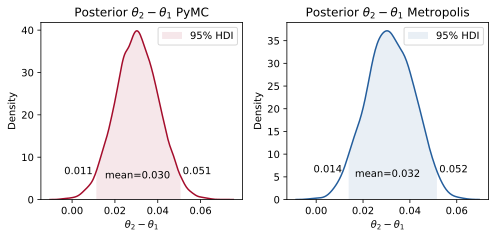

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

for i, (diff, method, color) in enumerate(
    zip(
        [diff_pymc, diff_our],
        ["PyMC", "Metropolis"],
        ["#a40c2b", "#235d9c"],
    )
):

    hdi = az.hdi(diff, 0.95)
    mean = diff.mean()
    kde = gaussian_kde(diff).pdf
    x = np.linspace(hdi[0], hdi[1], 100)
    y = kde(x)   
    
    sns.kdeplot(diff, ax=ax[i], color=color)
    ax[i].set_title(f"Posterior $\\theta_2 - \\theta_1$ {method}")
    ax[i].text(mean - 0.015, 5, f"mean={mean:.3f}")
    ax[i].text(hdi[0] - 0.015, 6, f"{hdi[0]:.3f}")
    ax[i].text(hdi[1] + 0.001, 6, f"{hdi[1]:.3f}")

    ax[i].fill_between(
        x, y, interpolate=True, color=color,
        edgecolor=None, alpha=0.1, label="95% HDI"
    )
    ax[i].legend()
    ax[i].set_xlabel("$\\theta_2 - \\theta_1$")
    
fig_path = os.path.join(
    usr, "Documents/site/assets/img/bayes_posterior.svg"
)
plt.tight_layout()
plt.savefig(fig_path, transparent=True)
plt.show()

In [607]:
with mp.Pool(4) as p:  # 4 chains in parallel
    chain = np.concatenate(
        p.map(
            lambda _: metropolis_sampling(f, [0.1, 0.1], 100_000),
            range(4),
        )
    )